In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10, 5]


In [2]:
def calStability(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:                
            target = rows[rows["method"]==m]
            _m = target[target["task_index"]==1][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            if m=="offline":
                continue
                
            
            _ideal = offline[offline["task_index"]==1]["accuracy"]
            val = float((_m["accuracy"]/float(_ideal)).sum()/len(_m))
            values[m].append(val)
    
    return values

In [3]:
def calPlasticity(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            _sum = 0.0
                
            target = rows[rows["method"]==m]
            train_session = target["train_session"].unique()
            
            if m=="offline":
                continue
    
            _m = target[target["train_session"]==(target["task_index"])][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            _ideal = offline["accuracy"]
            
            if len(_m) != len(_ideal):
                values[m].append(np.nan)
                continue
            
            val = _m["accuracy"].div(_ideal.values, axis=0).sum()/len(_m)
            
            # Make sure that determinator is not zero
            if np.isinf(val):
                _ideal = [d if d>0 else 1 for d in _ideal.values]
                val = np.nansum(_m["accuracy"].div(_ideal, axis=0))/len(_m)
            
            values[m].append(val)
            
    
    return values

In [4]:
def calOverallAcc(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            if m=="offline":
                continue
                    
            _sum = 0.0
                
            target = rows[rows["method"]==m]
            
            task_index = target["task_index"].unique()
            train_session = target["train_session"].unique()
            
            _m = target[target["train_session"]==len(task_index)][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            _ideal = offline["accuracy"]
            
            
            
            if len(_m) != len(_ideal):
#                 print("SKIP", m, t)
                values[m].append(np.nan)
                continue
            
            val = np.nansum(_m["accuracy"].div(_ideal.values, axis=0))/len(_m)
            
            # Make sure that determinator is not zero
            if np.isinf(val):
                _ideal = [d if d>0 else 1 for d in _ideal.values]
                val = np.nansum(_m["accuracy"].div(_ideal, axis=0))/len(_m)
            
            values[m].append(val)
            
    return values

In [5]:
all_values = {}
for d in ["HouseA", "CASAS", "PAMAP", "DSADS"]:
# for d in ["DSADS"]:
    dataset = d
    folder = "../../Results/"+dataset+"/exp_component_sensitivity/"
    
    raw = pd.read_csv(folder+"results.txt")
    raw.columns = [c.strip() for c in raw.columns]
    raw["train_session"] = pd.to_numeric(raw["train_session"], errors='coerce')
    
    cmd = raw["cmd"].unique()
    task_order = raw["task_order"].unique()
    method = raw["method"].unique()

    stability = []
    plasticity = []
    overallAcc = []

    for c in cmd:
       
        target = raw[raw["cmd"]==c]
        m = calStability(target, task_order, method)
        stability.append(m)
        
        m = calPlasticity(target, task_order, method)
        plasticity.append(m)
        
        m = calOverallAcc(target, task_order, method)
        overallAcc.append(m)
        
    all_values[d] = (stability, plasticity, overallAcc)
    print(d, "DONE")

HouseA DONE
CASAS DONE
PAMAP DONE
DSADS DONE


# Plots

In [8]:
from scipy import stats

def plot(values, title, width=0.85, offset_ratio=0, xticks=[], models=None, rotation=-45):
    
    plt.rcParams['figure.figsize'] = [10, 8]
    
    m = [] 
    merr = []
    if models is None:
        models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]

    # values[cmd]["sg-cgan"][task_order]
    for model in models:
        
        tmp = []
        tmperr = []
        for i, v in enumerate(values):
            avg = np.nanmean(v[model])
            err = stats.sem(v[model], nan_policy="omit")
            tmp.append(avg)
            tmperr.append(err)
            
        
        m.append(tmp)
        merr.append(tmperr)
    
    # m[model_index][cmd]
    print("Plot values")
    print(m[0])
    print(merr[0])
    
    ind = np.arange(len(xticks)) # the x locations for the groups

    fig, ax = plt.subplots()
    
    patterns = [ "/" , "\\" , "x" , "-" , "+" , "|", "o", "O", ".", "*" ]
    for i, model in enumerate(models):
        offset = (float(i)/len(models))*width
        offset -= (offset_ratio)*width
        ax.bar(ind + offset, m[i], width*(1.0/len(models)), yerr=merr[i], label=model, hatch=patterns[i])
        
        X = np.arange(-0.5, len(m[0])+0.5)
        Y = [m[i][0] for _ in range(len(X))]
        ax.plot(X, Y, linestyle=':')

    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(xticks, rotation=rotation, rotation_mode="default", fontdict={"fontsize":20})
#     ax.legend()

    fig.tight_layout()

    plt.show()
    

In [9]:
xticks = [
    "no extra components",
    "self-verify",
    "oversampling",
    "regularization [EWC]",
    "regularization [KD]",
    "instance noise",
    "all"
]

Plot values
[0.9039220261416535, 0.9132225030891894, 0.9039220261416535, 0.9585358371342412, 0.9712626426202011, 0.8967785383066424, 0.9461499177997258]
[0.054266170321848696, 0.045085395261991276, 0.054266170321848696, 0.03327777869594402, 0.03402070041829345, 0.06475316288814596, 0.04641769841274291]


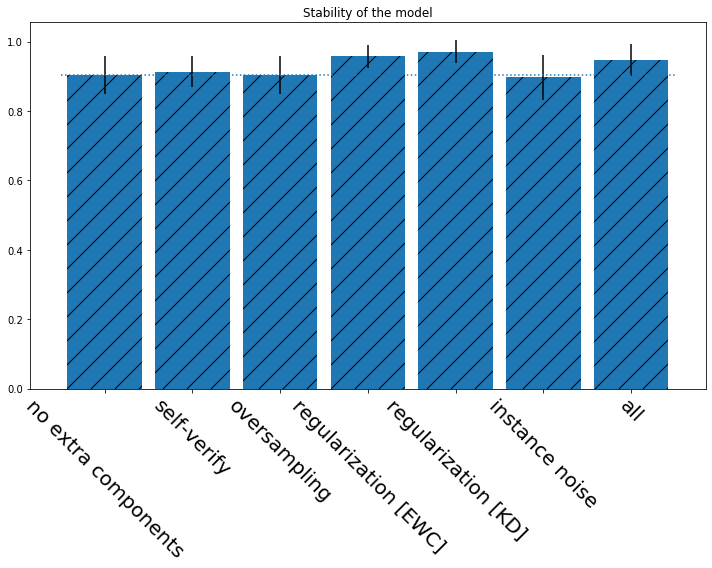

Plot values
[1.1233467412535842, 1.1172861351929781, 1.1233467412535842, 1.1109022140583076, 1.0607630857084682, 1.120191934805226, 1.0269990207046351]
[0.020812894615621285, 0.019441043655844075, 0.020812894615621285, 0.021533844371913222, 0.0190535282514743, 0.018238148114186236, 0.022437347379182477]


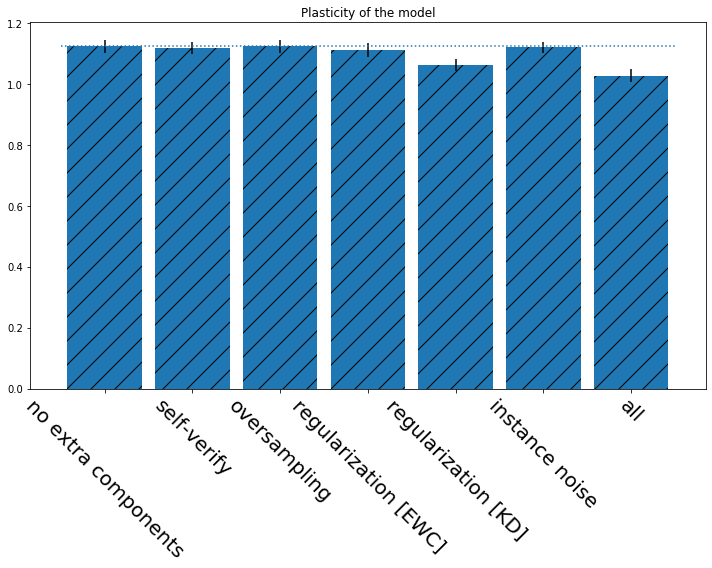

Plot values
[0.8410251911197371, 0.8533559710975759, 0.8410251911197371, 0.8740820178795324, 0.8671510211299734, 0.8207119556922997, 0.8185198303710429]
[0.04910553350287603, 0.03696957027662049, 0.04910553350287603, 0.027519900640222944, 0.041618701057891005, 0.042156568325059346, 0.04261758099202254]


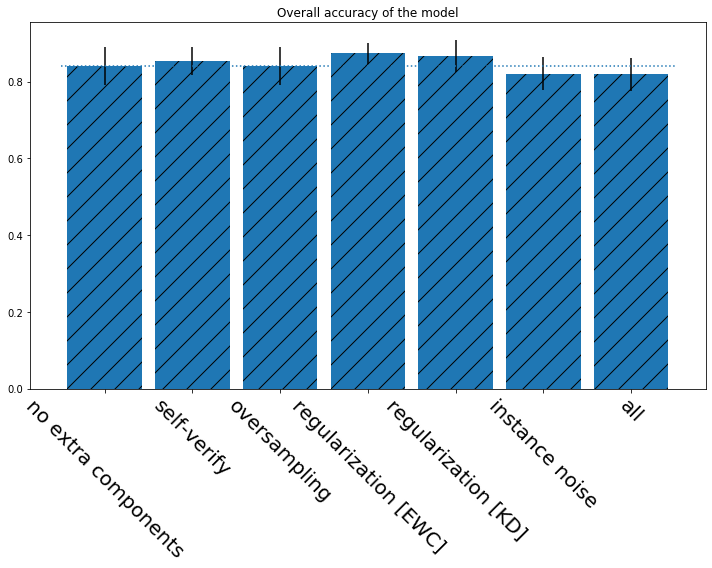

In [10]:
stability, plasticity, overallAcc = all_values["HouseA"]

models = ["sg-cgan"]
plot(stability, "Stability of the model", xticks=xticks, models=models)
plot(plasticity, "Plasticity of the model", xticks=xticks, models=models)
plot(overallAcc, "Overall accuracy of the model", xticks=xticks, models=models)

Plot values
[1.735213258723451, 1.8737889197200448, 1.735213258723451, 1.574025050015907, 2.379295475429976, 1.5293312351483432, 2.0382135587570707]
[0.6897566928786648, 0.7681121311045196, 0.6897566928786648, 0.6142250042413779, 1.0513208230523323, 0.5197703259687623, 0.7852376719048588]


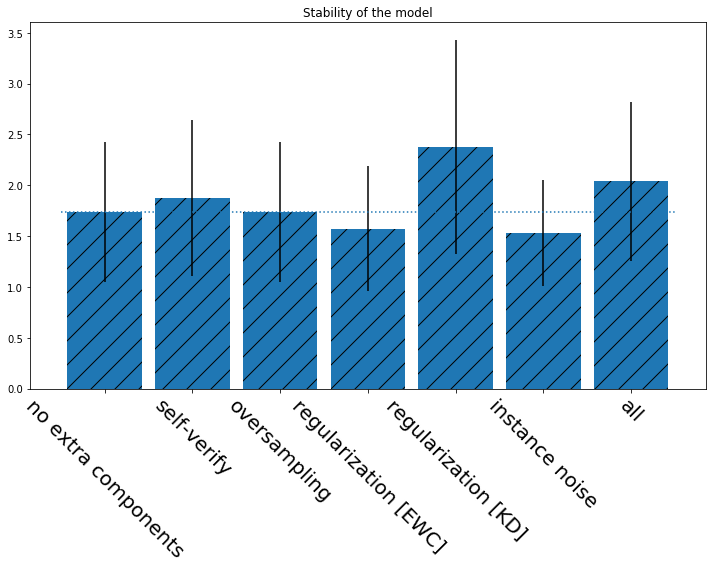

Plot values
[1.6824098562848495, 1.6825873373214661, 1.6824098562848495, 1.6856610337108897, 1.5236111469911642, 1.6865490014510964, 1.5456603211208768]
[0.3388320976480698, 0.3391184838086697, 0.3388320976480698, 0.3387633298194256, 0.35556672021987373, 0.338675578439714, 0.3350210110697076]


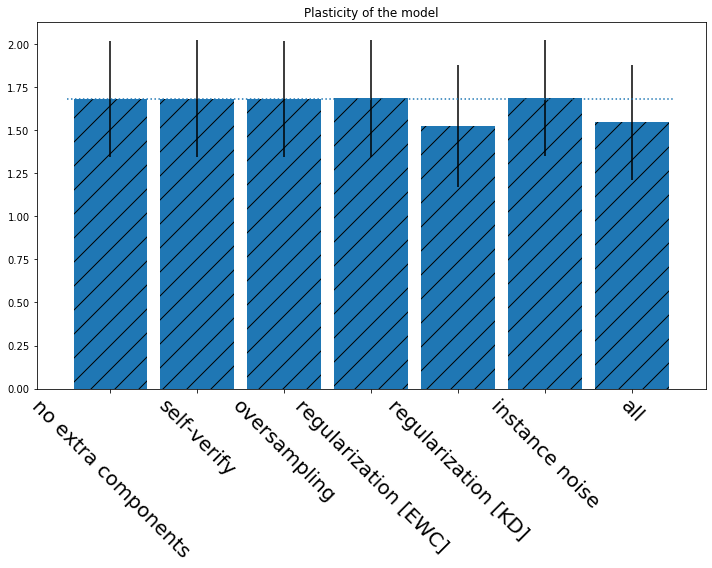

Plot values
[0.7429773490748088, 0.8149651977986168, 0.7429773490748088, 0.8066070227083582, 0.9397373953857964, 0.8639643632656406, 0.9952438393990889]
[0.07506516924816937, 0.11854160445113934, 0.07506516924816937, 0.10905367507535993, 0.13413715152782624, 0.09186572491045954, 0.0937613591746147]


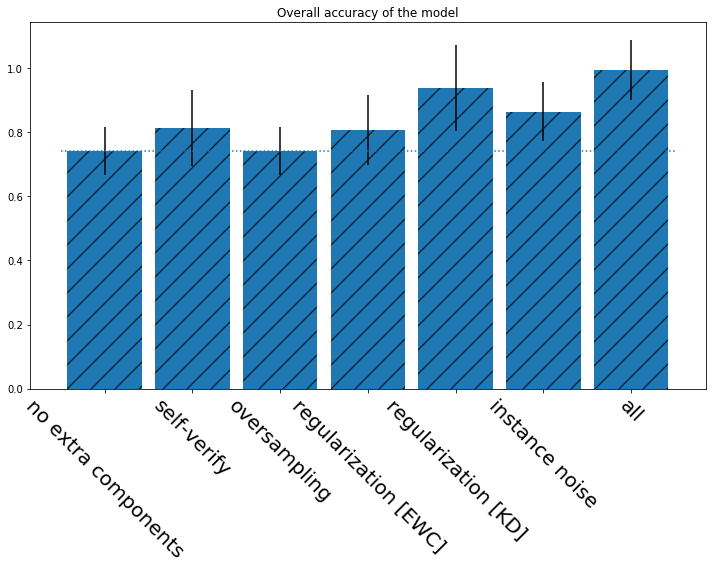

In [11]:

stability, plasticity, overallAcc = all_values["CASAS"]

models = ["sg-cgan"]
plot(stability, "Stability of the model", xticks=xticks, models=models)
plot(plasticity, "Plasticity of the model", xticks=xticks, models=models)
plot(overallAcc, "Overall accuracy of the model", xticks=xticks, models=models)

Plot values
[0.4477392776808956, 0.71467763540324, 0.7067505749740945, 0.5265625394899791, 0.7780018702454066, 0.7555412338564965, 0.7869954760280031]
[0.24278059999494525, 0.11590087699345418, 0.1428362018854095, 0.31310688199762426, 0.13274193140748608, 0.05768190663937123, 0.09647559835216228]


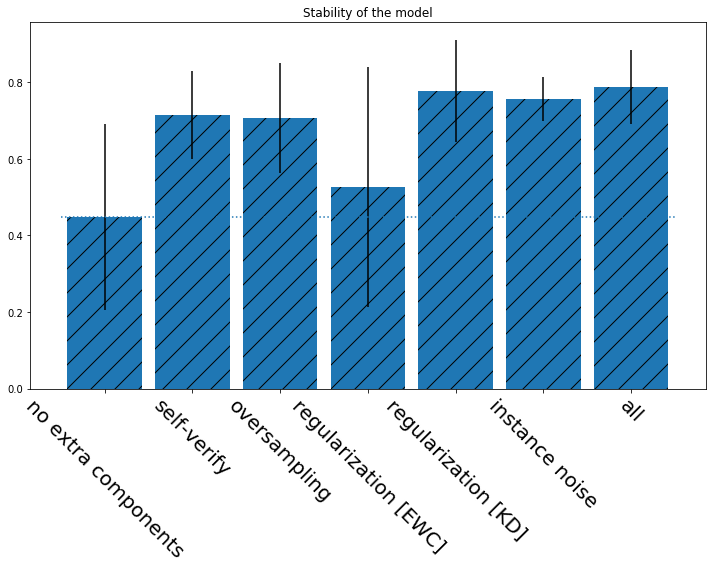

Plot values
[1.0882287801622517, 1.1094421218174495, 1.1168517550433155, 1.1182862836227057, 1.0326015020043968, 1.1129046406569438, 1.0542672726494815]
[0.029320759150278094, 0.0007215132281711555, 0.0069574978218169825, 0.004437972498630316, 0.015695752962028076, 0.004991947069727719, 0.004640748362492175]


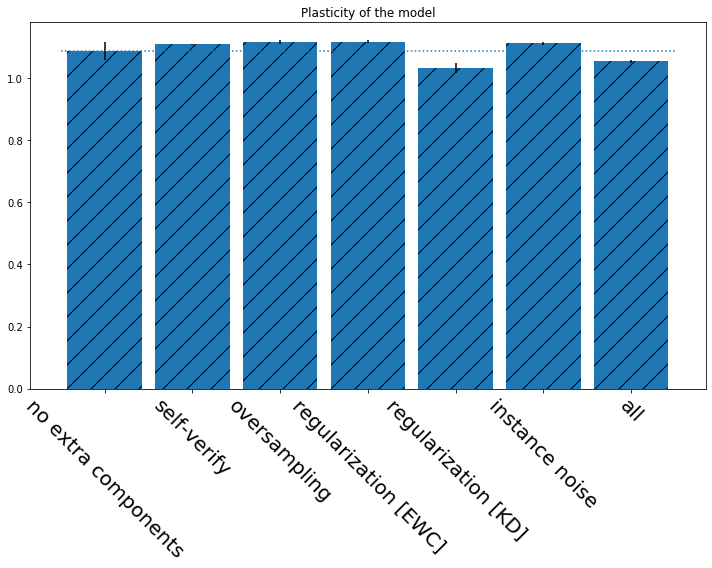

Plot values
[0.5903730436945157, 0.646298917054082, 0.6854680330918662, 0.575916786284871, 0.772126349185291, 0.7356149462902923, 0.823002849323452]
[0.2027609970863663, 0.09557036345639551, 0.05444297320025659, 0.12041351017502575, 0.012485495350915532, 0.010846217558640625, 0.029868808542570065]


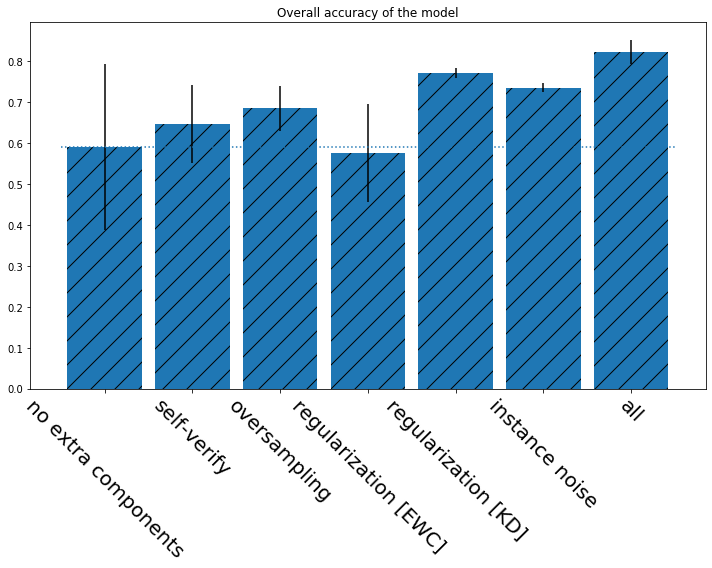

In [12]:

stability, plasticity, overallAcc = all_values["PAMAP"]

models = ["sg-cgan"]
plot(stability, "Stability of the model", xticks=xticks, models=models)
plot(plasticity, "Plasticity of the model", xticks=xticks, models=models)
plot(overallAcc, "Overall accuracy of the model", xticks=xticks, models=models)

Plot values
[0.8467532467532468, 0.7012987012987013, 0.6103896103896105, 0.5740259740259741, 1.3558441558441559, 0.6441558441558441, 0.8467532467532468]
[nan, nan, nan, nan, nan, nan, nan]


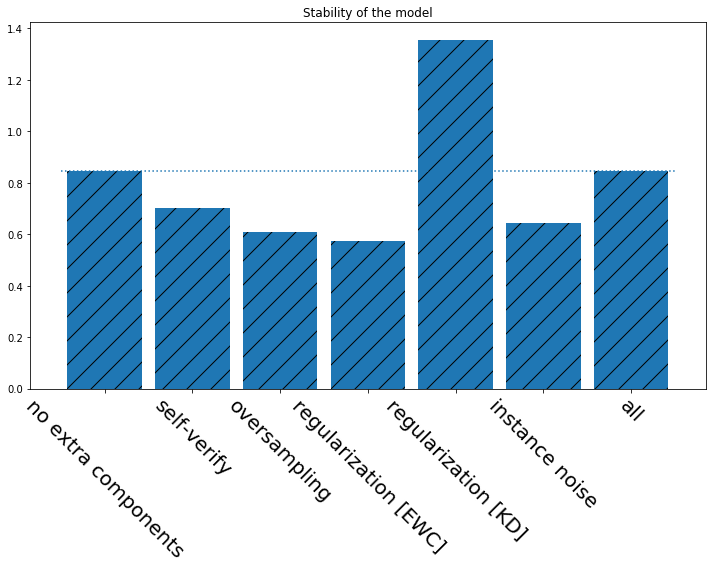

Plot values
[0.8496103896103897, 1.153664811379097, 1.153664811379097, 1.1456376004947433, 0.8583178726035869, 1.149692022263451, 0.8496103896103897]
[nan, nan, nan, nan, nan, nan, nan]


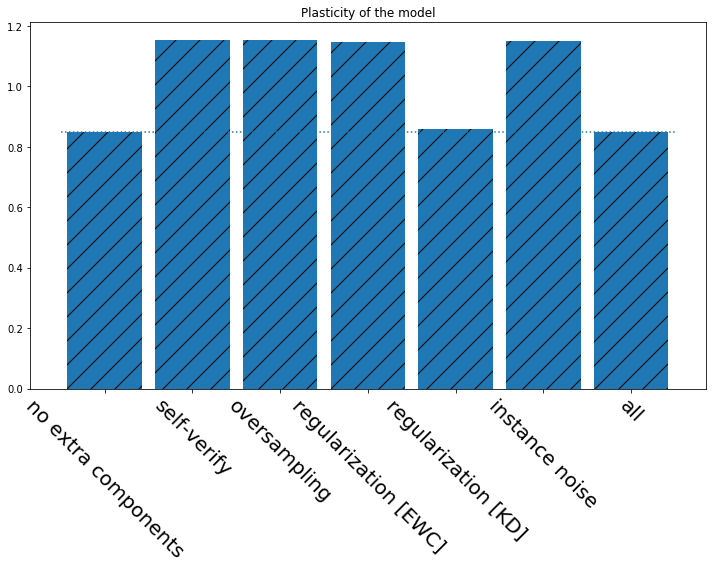

Plot values
[0.4289375386518244, 0.6227705627705629, 0.2, 0.2013333333333333, 0.3679134199134199, 0.2, 0.4289375386518244]
[nan, nan, nan, nan, nan, nan, nan]


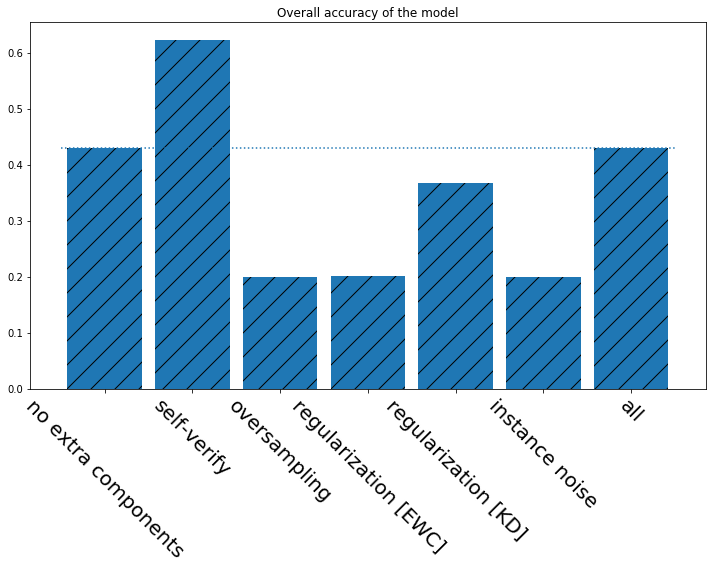

In [13]:

stability, plasticity, overallAcc = all_values["DSADS"]

models = ["sg-cgan"]
plot(stability, "Stability of the model", xticks=xticks, models=models)
plot(plasticity, "Plasticity of the model", xticks=xticks, models=models)
plot(overallAcc, "Overall accuracy of the model", xticks=xticks, models=models)